# Run a Periodogram Across Full ZTF Sources

This notebook is an adaptation of the Nested Dask [tutorial for loading HiPSCat data](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html).

There we loaded a small subset of ZTF DR 14, and here we will try to load a full ZTF DR 20 and run a `light-curve` package periodogram across all of ZTF on epyc.

## Install dependencies for the notebook

The notebook requires `nested-dask` and few other packages to be installed.
- `lsdb` to load and join "object" (pointing) and "source" (detection) ZTF catalogs
- `aiohttp` is `lsdb`'s optional dependency to download the data via web
- `light-curve` to extract features from light curves
- `matplotlib` to plot the results

In [ ]:
# Uncomment the following line to install nested-dask
# %pip install nested-dask

# Comment the following line to skip dependencies installation
#%pip install --quiet lsdb aiohttp light-curve matplotlib

In [ ]:
#%pip install --quiet git+https://github.com/astronomy-commons/lsdb.git

In [1]:
import dask.array
import dask.distributed
import light_curve as licu
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd
from dask_expr import from_legacy_dataframe
from lsdb import read_hats
from matplotlib.colors import LogNorm
from nested_dask import NestedFrame
import dask, lsdb, nested_dask

import dask.dataframe as dd

In [2]:
from datetime import datetime

In [3]:
# Print Version Info
print(f"LSDB verion: {lsdb.__version__}")
print(f"Nested-Dask verion: {nested_dask.__version__}")
print(f"Dask verion: {dask.__version__}")

LSDB verion: 0.4.2
Nested-Dask verion: 0.3.0
Dask verion: 2024.10.0


# Configuration for this Particular Run

In [15]:
n_workers = 16 
memory_per_worker = 20 # in GB
threads_per_worker = 2 # We want 10 GB per worker thread
partition_chunk_size = 10


Some additional setup for using Dask on epyc:

In [5]:
import dask
dask.config.set({
    'temporary-directory' :'/epyc/ssd/users/wbeebe/tmp',
    'distributed.comm.timeouts.connect': '1200s',
    'distributed.comm.timeouts.tcp': '1200s',
    #'dataframe_optimize':None,
    #'delayed_optimize':None,
    #'dataframe.shuffle.method': shuffle_method,
})

dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/astro/users/wbeebe/.conda/envs/period_chunking/lib/python3.12/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## Load ZTF DR14
For the demonstration purposes we use a light version of the ZTF DR14 catalog distributed by LINCC Frameworks, a half-degree circle around RA=180, Dec=10.
We load the data from HTTPS as two LSDB catalogs: objects (metadata catalog) and source (light curve catalog).

## Setup cone search
Here we use a cone search for the LSDB load to keep our data small

In [6]:
from lsdb.core.search import ConeSearch
# A tiny cone search
search_area = ConeSearch(ra=254, dec=35, radius_arcsec=4.0 * 3600)

In [7]:
catalogs_dir = "/data3/epyc/data3/hats/catalogs/ztf_dr14"


lsdb_object = read_hats(
    f"{catalogs_dir}/ztf_object",
    columns=["ra", "dec", "ps1_objid"],
    search_filter=search_area,
)
lsdb_source = read_hats(
    f"{catalogs_dir}/ztf_source",
    columns=["mjd", "ra", "dec", "mag", "magerr", "band", "ps1_objid", "catflags"],
    #search_filter=search_area,
)
lc_columns = ["mjd", "mag", "magerr", "band", "catflags"]

We need to merge these two catalogs to get the light curve data.
It is done with LSDB's `.join_nested()` method which would give us a new catalog with a nested frame of ZTF sources. For this tutorial we'll just use the underlying nested dataframe for the rest of the analysis rather than the LSDB catalog directly.

In [8]:
# Nesting Sources into Object
nested_ddf = lsdb_object.join_nested(lsdb_source, left_on="ps1_objid", right_on="ps1_objid", nested_column_name="lc")

# TODO remove once have added LSDB wrappers for nested_dask (reduce, dropna, etc)
nested_ddf = nested_ddf._ddf

/astro/users/wbeebe/.conda/envs/period_chunking/lib/python3.12/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [9]:
print(f"# of partitions: {nested_ddf.npartitions}")

# of partitions: 85


## Convert LSDB joined catalog to `nested_dask.NestedFrame`

First, we plan the computation to convert the joined Dask DataFrame to a NestedFrame.

Now we filter our dataframe by the `catflags` column (0 flags correspond to the perfect observational conditions) and the `band` column to be equal to `r`.
After filtering the detections, we are going to count the number of detections per object and keep only those objects with more than 10 detections.

In [10]:
r_band = nested_ddf.query("lc.catflags == 0 and lc.band == 'r'")
nobs = r_band.reduce(np.size, "lc.mjd", meta={0: int}).rename(columns={0: "nobs"})
r_band = r_band[nobs["nobs"] > 10]
r_band

,ra,dec,ps1_objid,lc
npartitions=85,,,,
654921902061518848,double[pyarrow],double[pyarrow],int64[pyarrow],"nested<mjd: [double], ra: [double], dec: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
654992270805696512,...,...,...,...
...,...,...,...,...
676665844012417024,...,...,...,...
676736212756594688,...,...,...,...


Later we are going to extract features, so we need to prepare light-curve data to be in the same float format.

### Extract features from ZTF light curves

Now we are going to extract some features:
- Top periodogram peak
- Mean magnitude
- Von Neumann's eta statistics
- Excess variance statistics
- Number of observations

We are going to use [`light-curve`](https://github.com/light-curve/light-curve-python) package for this purposes

In [11]:
extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        max_freq_factor=1.0, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=True,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = r_band.reduce(
    extract_features,
    "lc.mjd",
    "lc.mag",
    meta={name: np.float32 for name in extractor.names},
)

df_w_features = r_band.join(features)
df_w_features

,ra,dec,ps1_objid,lc,period_0,period_s_to_n_0
npartitions=85,,,,,,
654921902061518848,double[pyarrow],double[pyarrow],int64[pyarrow],"nested<mjd: [double], ra: [double], dec: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>",float32,float32
654992270805696512,...,...,...,...,...,...
...,...,...,...,...,...,...
676665844012417024,...,...,...,...,...,...
676736212756594688,...,...,...,...,...,...


Before we are going next and actually run the computation, let's create a Dask client which would allow us to run the computation in parallel.

In [12]:
client = dask.distributed.Client(
    n_workers=n_workers, 
    threads_per_worker=threads_per_worker, 
    memory_limit=f"{memory_per_worker}GB",
    processes=True, # Does not use the threaded scheduler
)
client

/astro/users/wbeebe/.conda/envs/period_chunking/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33045 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33045/status,
Dashboard: http://127.0.0.1:33045/status,Workers: 16
Total threads: 32,Total memory: 298.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46678,Workers: 16
Dashboard: http://127.0.0.1:33045/status,Total threads: 32
Started: Just now,Total memory: 298.02 GiB
Comm: tcp://127.0.0.1:40942,Total threads: 2
Dashboard: http://127.0.0.1:45604/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:35073,


## Chunking attempts

This solution results in intractable memory usage and uses up too much time

In [ ]:
# This solution results in intractable memory usage and uses up too much time

now = datetime.now()
start_time = now.strftime("%m_%d_%H_%M_%S")

intermediate_res = []
#df_w_features = df_w_features.drop(columns=["period_0", "period_s_to_n_0"])
total_partitions = df_w_features.npartitions
chunk_size = partition_chunk_size
print(f"{total_partitions} partitions chunked into {total_partitions//chunk_size + (0 if total_partitions % chunk_size == 0 else 1)} chunks with {chunk_size} partitions each")
for start_partition in range(0, total_partitions, chunk_size):
    end_partition = min(start_partition + chunk_size, total_partitions)
    curr_chunk = df_w_features.partitions[start_partition: end_partition]
    intermediate_res.append(curr_chunk.compute())
    print(f"intermediate_res {type(intermediate_res[-1])}")
res_frame = dd.concat(intermediate_res)
print(f"res_frame {type(res_frame)}")

lg_period_bins = np.linspace(-1, 2, 101)
lg_snr_bins = np.linspace(0, 2, 101)

# TODO can we convert more efficiently here?
lg_period = dask.array.log10(dask.array.asarray(res_frame["period_0"].values))
lg_snr = dask.array.log10(dask.array.asarray(res_frame["period_s_to_n_0"].values))

hist2d = dask.array.histogram2d(
    lg_period,
    lg_snr,
    bins=[lg_period_bins, lg_snr_bins],
)
# Run the computation
hist2d = hist2d[0].compute()

# Plot the 2D histogramm,  j
plt.imshow(
    hist2d.T,
    extent=(lg_period_bins[0], lg_period_bins[-1], lg_snr_bins[0], lg_snr_bins[-1]),
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.colorbar(label="Number of stars")
plt.xlabel("lg Period/day")
plt.ylabel("lg S/N")

later = datetime.now()
current_time = later.strftime("%m_%d_%H_%M_%S")
plt.savefig(f"ztf_periodogram_chunk_start_{start_time}_end_{current_time}.png")
print(f"Time elapsed in seconds: {later - now}")

This attempts isolating the computation on a per-partition basis. It's slower than the solution below but actually completes

In [ ]:
# Set up bins for histogram
lg_period_bins = np.linspace(-1, 2, 101)
lg_snr_bins = np.linspace(0, 2, 101)

now = datetime.now()
start_time = now.strftime("%m_%d_%H_%M_%S")

# Create empty histogram array for accumulation
final_hist2d = np.zeros((len(lg_period_bins) - 1, len(lg_snr_bins) - 1))

# Divide the DataFrame into delayed partitions
partitions = df_w_features.to_delayed()

for partition in partitions:
    # Convert partition to a Pandas DataFrame
    partition_df = dask.compute(partition)[0]

    # Calculate log values and filter out non-positive values (since log10 can't take 0 or negative)
    lg_period = np.log10(partition_df["period_0"].replace(0, np.nan).dropna())
    lg_snr = np.log10(partition_df["period_s_to_n_0"].replace(0, np.nan).dropna())

    # Compute partial histogram
    hist2d, _, _ = np.histogram2d(
        lg_period,
        lg_snr,
        bins=[lg_period_bins, lg_snr_bins],
    )

    # Accumulate into final histogram
    final_hist2d += hist2d

# Plot the accumulated 2D histogram
plt.imshow(
    final_hist2d.T,
    extent=(lg_period_bins[0], lg_period_bins[-1], lg_snr_bins[0], lg_snr_bins[-1]),
    origin="lower",
    norm=LogNorm(vmin=1, vmax=final_hist2d.max()),
)
plt.colorbar(label="Number of stars")
plt.xlabel("lg Period/day")
plt.ylabel("lg S/N")

later = datetime.now()
current_time = later.strftime("%m_%d_%H_%M_%S")
plt.savefig(f"ztf_periodogram_start_{start_time}_end_{current_time}.png")
print(f"Time elapsed in seconds: {later - now}")


## Construct per-partition histograms with to_delayed

This actually completes on small workflows in a timely fashion and seems to help Dask be more memory efficient,
but still needs to be tested at a larger scale.

Time elapsed in seconds: 0:01:34.549297


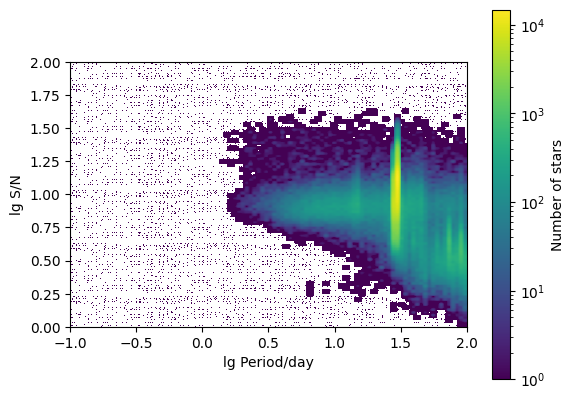

In [20]:

# Set up bins for histogram
lg_period_bins = np.linspace(-1, 2, 101)
lg_snr_bins = np.linspace(0, 2, 101)

now = datetime.now()
start_time = now.strftime("%m_%d_%H_%M_%S")

# Create empty histogram array for accumulation
lg_period_bin_count = len(lg_period_bins) - 1
lg_snr_bin_count = len(lg_snr_bins) - 1

# Function to compute histogram for each partition
def compute_partition_histogram(partition_df):
    # Calculate log values and filter out non-positive values (since log10 can't take 0 or negative)
    lg_period = np.log10(partition_df["period_0"].replace(0, np.nan).dropna())
    lg_snr = np.log10(partition_df["period_s_to_n_0"].replace(0, np.nan).dropna())
    
    # Compute the histogram for the partition
    hist2d, _, _ = np.histogram2d(
        lg_period,
        lg_snr,
        bins=[lg_period_bins, lg_snr_bins]
    )
    return hist2d

# Apply histogram computation to each partition
partitions = df_w_features.to_delayed()
delayed_histograms = [dask.delayed(compute_partition_histogram)(partition) for partition in partitions]

# Use dask to combine all partition-level histograms
total_hist2d = dask.delayed(sum)(delayed_histograms)

# Compute the final combined histogram
final_hist2d = total_hist2d.compute()

# Plot the accumulated 2D histogram
plt.imshow(
    final_hist2d.T,
    extent=(lg_period_bins[0], lg_period_bins[-1], lg_snr_bins[0], lg_snr_bins[-1]),
    origin="lower",
    norm=LogNorm(vmin=1, vmax=final_hist2d.max()),
)
plt.colorbar(label="Number of stars")
plt.xlabel("lg Period/day")
plt.ylabel("lg S/N")

later = datetime.now()
current_time = later.strftime("%m_%d_%H_%M_%S")
plt.savefig(f"ztf_periodogram_start_{start_time}_end_{current_time}.png")
print(f"Time elapsed in seconds: {later - now}")



Computing partitions 0 to 10
Computing partitions 10 to 20
Computing partitions 20 to 30
Computing partitions 30 to 40
Computing partitions 40 to 50
Computing partitions 50 to 60
Computing partitions 60 to 70
Computing partitions 70 to 80
Computing partitions 80 to 85
Time elapsed in seconds: 0:04:12.063529


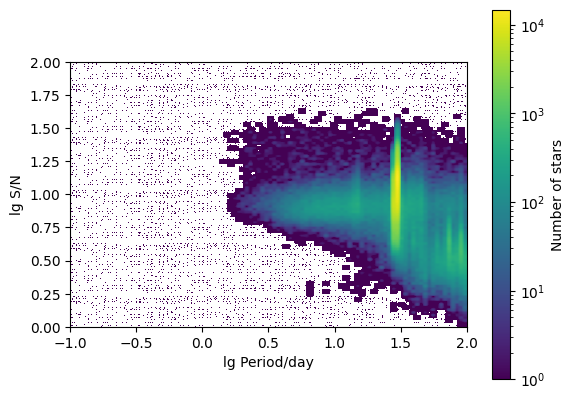

In [19]:

# Set up bins for histogram
lg_period_bins = np.linspace(-1, 2, 101)
lg_snr_bins = np.linspace(0, 2, 101)

now = datetime.now()
start_time = now.strftime("%m_%d_%H_%M_%S")

# Create empty histogram array for accumulation
lg_period_bin_count = len(lg_period_bins) - 1
lg_snr_bin_count = len(lg_snr_bins) - 1

# Function to compute histogram for each partition
def compute_partition_histogram(partition_df):
    # Calculate log values and filter out non-positive values (since log10 can't take 0 or negative)
    lg_period = np.log10(partition_df["period_0"].replace(0, np.nan).dropna())
    lg_snr = np.log10(partition_df["period_s_to_n_0"].replace(0, np.nan).dropna())
    
    # Compute the histogram for the partition
    hist2d, _, _ = np.histogram2d(
        lg_period,
        lg_snr,
        bins=[lg_period_bins, lg_snr_bins]
    )
    return hist2d

# Apply histogram computation to each partition
partitions = df_w_features.to_delayed()
# Create empty histogram array for accumulation
final_hist2d = np.zeros((len(lg_period_bins) - 1, len(lg_snr_bins) - 1))
#delayed_histograms = [dask.delayed(compute_partition_histogram)(partition) for partition in partitions]
for part_idx_start in range(0, len(partitions), partition_chunk_size):
    part_idx_end = min(part_idx_start + partition_chunk_size, len(partitions))
    hist_chunk = dask.delayed(sum)([dask.delayed(compute_partition_histogram)(part) for part in partitions[part_idx_start:part_idx_end]])
    print(f"Computing partitions {part_idx_start} to {part_idx_end}")
    hist_chunk = hist_chunk.compute()
    final_hist2d += hist_chunk

# Use dask to combine all partition-level histograms
#total_hist2d = dask.delayed(sum)(delayed_histograms)

# Compute the final combined histogram
#final_hist2d = total_hist2d.compute()

# Plot the accumulated 2D histogram
plt.imshow(
    final_hist2d.T,
    extent=(lg_period_bins[0], lg_period_bins[-1], lg_snr_bins[0], lg_snr_bins[-1]),
    origin="lower",
    norm=LogNorm(vmin=1, vmax=final_hist2d.max()),
)
plt.colorbar(label="Number of stars")
plt.xlabel("lg Period/day")
plt.ylabel("lg S/N")

later = datetime.now()
current_time = later.strftime("%m_%d_%H_%M_%S")
save_path = "/astro/users/wbeebe/nested/period_chunking/notebooks_lf/notebooks_lf/ztf_periodogram/chunking/"
plt.savefig(f"{save_path}_ztf_periodogram_start_{start_time}_end_{current_time}.png")
print(f"Time elapsed in seconds: {later - now}")



In [21]:
client.close()